The objective of the project is to carryout an analysis on database form global online store Ice to identify patterns that determine whether a game succeeds or not.

# Step 1:

In [376]:
#importing variables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [377]:
#reading the csv into pandas df and viewing sample of the df.

df_game = pd.read_csv('../games.csv')
df_game.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
1774,Tak and the Power of Juju,PS2,2003.0,Platform,0.56,0.44,0.00,0.15,68.0,9,E
11712,Krazy Ivan,PS,1995.0,Simulation,0.04,0.03,0.00,0.00,NaN,NaN,NaN
7336,Petz: Horse Club,Wii,2008.0,Misc,0.20,0.00,0.00,0.02,NaN,tbd,E
5150,Scribblenauts: Unlimited,WiiU,2012.0,Action,0.25,0.09,0.00,0.03,73.0,7.4,E10+
5581,Dead Rising 2: Off the Record,PS3,2011.0,Action,0.11,0.08,0.10,0.03,72.0,7.1,M
6738,U-Sing: Girls Night,Wii,2010.0,Misc,0.00,0.21,0.00,0.04,NaN,NaN,NaN
12563,Another Code R: A Journey into Lost Memories,Wii,2009.0,Adventure,0.00,0.03,0.03,0.00,66.0,NaN,NaN
14119,S.T.A.L.K.E.R.: Clear Sky,PC,2008.0,Shooter,0.00,0.03,0.00,0.01,75.0,7.7,M
965,DDRMAX2: Dance Dance Revolution,PS2,2003.0,Simulation,1.05,0.59,0.00,0.18,82.0,8.2,E
828,Ghostbusters: The Video Game (DS Version),PS3,2010.0,Action,0.60,0.96,0.13,0.36,NaN,NaN,NaN


# Step 2. Prepare the data

In [378]:
df_game.columns = df_game.columns.str.lower() #converting the columns to lower case.
df_game.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2939,LEGO Rock Band,Wii,2009.0,Misc,0.41,0.22,0.0,0.06,70.0,6.8,E10+


In [379]:
df_game.info() #exploring the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


* The name, year_of_release, genre, critic_score, and rating columns have some missing values.

* The name, platform, genre,and the rating column are type object which is ok.
 
* the na_sales, eu_sales, jp_sales, other_sales, critic_score are in float type, which is ok. 

* Meanwhile the year will be converted to datetime for easy calculation since the zeros are not meaningful.

* User_score will be converted from object format to float type.


In [380]:
df_game.platform.unique() #exploring the unique values in the platform.

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

* The missing value is 6701 and tbd (to be determined) is 2424.

* Therefor, droping these values will significantly affect the df.

* The values will be replaced with median values since it is hard to tell what those values represent. 

* Also, the median is chosing since they are not affected the outliers.

In [382]:
#Assessing the pattern in the NAN values:
df_NAN = df_game.isna() #creating a df for the nan values to observe the pattern. 
#display (df_NAN)
df_NAN.sample(10)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1898,False,False,False,False,False,False,False,False,False,False,False
14447,False,False,False,False,False,False,False,False,False,False,False
2049,False,False,False,False,False,False,False,False,False,False,False
4703,False,False,False,False,False,False,False,False,False,False,False
842,False,False,False,False,False,False,False,False,False,False,False
1968,False,False,False,False,False,False,False,False,True,True,True
12917,False,False,False,False,False,False,False,False,False,False,False
14669,False,False,False,False,False,False,False,False,True,True,True
924,False,False,False,False,False,False,False,False,True,True,True
8835,False,False,False,False,False,False,False,False,False,False,False


 df_NAN sample showed that there is relationship between NAN values in critic_score and the user_score/rating.

* Since the critic score has the most nan values, let's creat df where critics is nan to assess their relationship with platform and rating. 

* This will help identify if the nan for rating is due to defeciency of the platform or if is associated with the population (example, teen or adult).

In [383]:
nsn_critic_score = df_game[df_game.critic_score.isna()] 
nsn_critic_score.rating.value_counts() #shows  population and the nan on the critic value.
#sn_critic_score.platform.groupby('critic_score').size()




rating
E       1182
T        321
E10+     302
M         80
EC         8
K-A        2
Name: count, dtype: int64

In [384]:

nsn_critic_score.genre.value_counts() #show how the nan in the rating are distributed along the genre


genre
Action          1479
Misc            1227
Sports          1154
Adventure        980
Role-Playing     761
Simulation       521
Racing           507
Fighting         440
Platform         391
Strategy         381
Shooter          379
Puzzle           356
Name: count, dtype: int64

In [385]:
nsn_critic_score = df_game[df_game.critic_score.isna()] 
nsn_critic_score.platform.value_counts() #shows the relationship between the missing value and the platform.
#sn_critic_score.platform.groupby('critic_score').count()

platform
DS      1434
PS       997
PS2      863
PSP      747
Wii      735
PS3      511
GBA      384
3DS      352
X360     346
N64      319
PSV      310
PC       259
SNES     239
SAT      173
PS4      140
2600     133
GC       108
XB        99
GB        98
NES       98
XOne      78
WiiU      57
DC        38
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: count, dtype: int64

In [386]:
nsn_critic_score = df_game[df_game.critic_score.isna()] 
nsn_critic_score.genre.value_counts() #shows the relationship between the missing value and the genre

genre
Action          1479
Misc            1227
Sports          1154
Adventure        980
Role-Playing     761
Simulation       521
Racing           507
Fighting         440
Platform         391
Strategy         381
Shooter          379
Puzzle           356
Name: count, dtype: int64

In [387]:
df_game_ps = df_game[df_game.platform=='PS']
df_game_ps.sample(5)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1019,Star Wars Episode I: The Phantom Menace,PS,1999.0,Adventure,0.72,0.89,0.04,0.10,NaN,NaN,NaN
6806,K-1 Revenge,PS,1997.0,Fighting,0.04,0.03,0.16,0.02,NaN,NaN,NaN
5973,Jeopardy! 2nd Edition,PS,2000.0,Misc,0.16,0.11,0.00,0.02,NaN,NaN,NaN
10775,Shadow Master,PS,1997.0,Adventure,0.05,0.04,0.00,0.01,NaN,NaN,NaN
9253,Houshinengi,PS,1998.0,Strategy,0.00,0.00,0.13,0.01,NaN,NaN,NaN


In [388]:
df_game_nan=df_game[['critic_score', 'critic_score', 'rating']].copy().isna()
df_game_nan.sample(10)

,critic_score,critic_score,rating
15363,True,True,True
7719,True,True,True
6977,False,False,False
4382,True,True,True
6261,False,False,False
13649,True,True,True
15998,True,True,True
2917,False,False,False
5419,True,True,True
12805,True,True,False


In [389]:
nsn_critic_score.genre.value_counts()

genre
Action          1479
Misc            1227
Sports          1154
Adventure        980
Role-Playing     761
Simulation       521
Racing           507
Fighting         440
Platform         391
Strategy         381
Shooter          379
Puzzle           356
Name: count, dtype: int64

In [390]:
nsn_critic_score.rating.value_counts()

rating
E       1182
T        321
E10+     302
M         80
EC         8
K-A        2
Name: count, dtype: int64

* From the assessment of the NAN values, it is noted that the NAN are associated with some critic_score, the user_score and rating are mostly NAN value.
* More nan occured in E rating (1182), followed by T(320), and E10+(320); 

* Action film (1479) and Sports 1154 have hign nan

* It can be assume that the missing values are mostly associated with the young people.

* No pattern identified in the missing values on the year of release.


#Filling the NAN values.

* The nan value in the year  and rating will be filled with the mode values.
* The nan values in the critic score and user score will be filled with the median (to avoid biases and impact of outliers)

In [391]:
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [392]:
df_game.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
9276,Shinobido 2: Tales of the Ninja,PSV,2011.0,Action,0.04,0.05,0.02,0.02,NaN,NaN,NaN


In [393]:
# Fill NaNs with the mode of 'Year_of_Release'in relation to their name.
df_game['year_of_release']=df_game[['name', 'year_of_release']].groupby('name').transform(lambda x:x.fillna(x.mode()))



In [394]:
df_tbd = df_game[df_game['user_score']=='tbd']
df_tbd.sample(10)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13034,Strawberry Shortcake: Strawberryland Games,DS,2006.0,Action,0.05,0.00,0.0,0.00,NaN,tbd,E
11449,Murder in Venice,DS,2011.0,Adventure,0.05,0.02,0.0,0.01,NaN,tbd,E10+
4284,NASCAR 2005: Chase for the Cup,XB,2004.0,Racing,0.34,0.10,0.0,0.02,86.0,tbd,E
9786,Rush,PSP,2006.0,Racing,0.11,0.00,0.0,0.01,55.0,tbd,T
4921,Monster Jam: Urban Assault,DS,2008.0,Racing,0.36,0.00,0.0,0.03,NaN,tbd,E
12298,Crime Lab: Body of Evidence,DS,2010.0,Adventure,0.05,0.01,0.0,0.00,53.0,tbd,T
10255,The Scorpion King: Rise of the Akkadian,GC,2002.0,Action,0.08,0.02,0.0,0.00,49.0,tbd,T
3158,Up,DS,2009.0,Action,0.30,0.27,0.0,0.07,NaN,tbd,E
13906,PopStar Guitar,PS2,2008.0,Misc,0.02,0.01,0.0,0.00,NaN,tbd,T
11957,Yoostar on MTV,X360,NaN,Misc,0.07,0.00,0.0,0.01,49.0,tbd,T


In [395]:
df_game['user_score'].unique() 

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

* #user score has some str values. 
* #no pattern identified in the "tbd" values. Therefore, the value will be treated as nan values.

In [396]:
#converting the str values in user score to the type float.
df_game['user_score'] = pd.to_numeric(df_game['user_score'], errors='coerce')
df_game['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

In [397]:
df_game['genre'] = df_game['genre'].fillna(df_game['genre'].mode()[0])  #filled the nan value in genre with mode.
df_game['name'] = df_game['name'].fillna('unknown') #filled the nan value in name with unknown
#This is because it not clear what values the name and the genre represent.

df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [ ]:

df_game['user_score'] = df_game['user_score'].fillna(df_game.groupby(['genre', 'platform'])
                                                     ['user_score'].transform(lambda x:x.fillna(x.median())))
#replacing missing critic scores with the median score ensures that analyses remain unbiased.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       15588 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [399]:
df_game['user_score'] = df_game['user_score'].fillna(df_game.groupby(['genre', 'platform'])
                                                     ['user_score'].transform(lambda x:x.fillna(x.median())))
#replacing missing user score with the median score ensures that analyses remain unbiased.


# Convert 'Year_of_Release' to datetime format to allow for easy analysis
df_game['year_of_release'] = pd.to_datetime(df_game['year_of_release'], format='%Y')


# Fill NaNs with the mode of 'Year_of_Release' since it is hard to identify pattern with the name. 
df_game['year_of_release'] = df_game['year_of_release'].fillna(df_game['year_of_release'].mode()[0]) 


df_game['critic_score'] = df_game['critic_score'].fillna(df_game.groupby(['platform','genre'])
                                                         ['critic_score'].transform(lambda x:x.fillna(x.median())))
 #replacing missing critic scores with the median score ensures that analyses remain unbiased.


# filling NaNs with a placeholder such as 'Not Rated' is standard practice.
df_game['rating'] = df_game['rating'].fillna('Not Rated')


df_game.info()






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16715 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16715 non-null  datetime64[ns]
 3   genre            16715 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     15581 non-null  float64       
 9   user_score       15588 non-null  float64       
 10  rating           16715 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


In [400]:
df_game['user_score'] = df_game['user_score'].fillna(df_game.groupby(['genre'])
                                                     ['user_score'].transform(lambda x:x.fillna(x.median())))
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16715 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16715 non-null  datetime64[ns]
 3   genre            16715 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     15581 non-null  float64       
 9   user_score       16715 non-null  float64       
 10  rating           16715 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


In [401]:
df_game['critic_score'] = df_game['critic_score'].fillna(df_game.groupby(['genre'])
                                                         ['critic_score'].transform(lambda x:x.fillna(x.median())))
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16715 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16715 non-null  datetime64[ns]
 3   genre            16715 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     16715 non-null  float64       
 9   user_score       16715 non-null  float64       
 10  rating           16715 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


* In the above section, the nan values were replaced since the volum is significant and removing them will impact the result of the analysis. 
* The categorical data such as year of release were replaced with the mode value. 
* The continous data such as the critic sore and user score were replace with median value to remove biases and affect of outlier. 
* The nan in rating were filled with not rated since the absence of value could possible mean that the users those were not rated. 

Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [402]:
df_game.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [403]:
df_game['total_sale'] = df_game[['eu_sales','jp_sales','na_sales', 'other_sales']].sum(axis=1)
df_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16715 non-null  object        
 1   platform         16715 non-null  object        
 2   year_of_release  16715 non-null  datetime64[ns]
 3   genre            16715 non-null  object        
 4   na_sales         16715 non-null  float64       
 5   eu_sales         16715 non-null  float64       
 6   jp_sales         16715 non-null  float64       
 7   other_sales      16715 non-null  float64       
 8   critic_score     16715 non-null  float64       
 9   user_score       16715 non-null  float64       
 10  rating           16715 non-null  object        
 11  total_sale       16715 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 1.5+ MB


# Step 3. Analyze the data

Dertermine the games  released in different years and their significant. 

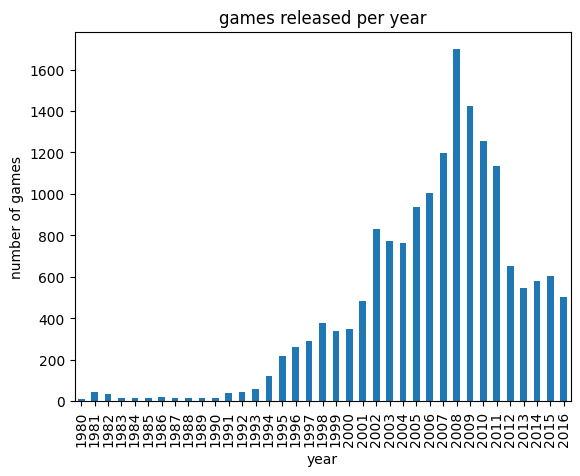

In [404]:
#extract year from 'Year' column
df_game['year_release'] = df_game['year_of_release'].dt.year
# Count games released per year
games_per_year = df_game.groupby('year_release')
games_per_year.size().plot(kind='bar')
plt.title("games released per year")
plt.xlabel("year")
plt.ylabel("number of games")
plt.show()

* The bar chart suggest that the highest sales occured in 2008, 2009, and 2010, respectively. 

* It can be said that the their mojor sales occured between 2002 and 2011.

* That there is significant difference between the observed and expected distributions, indicating that the number of games released each year varies ignificantly.
* The data for every period significant is not signicant and can be dropped

Analyze Sales Trends Over Time for Each Platform:

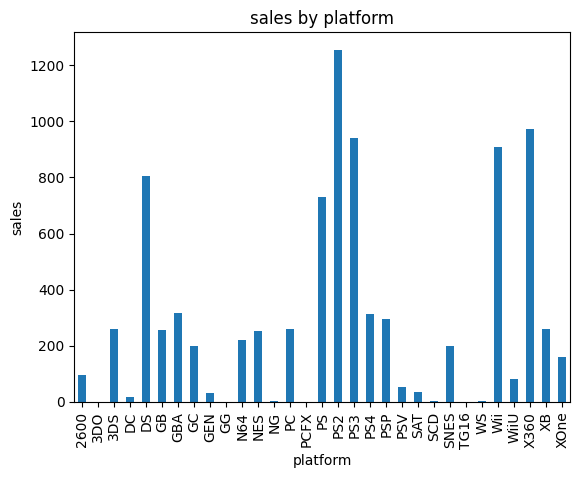

In [405]:
# Analyzing how sales varied from platform to platform using Bar Chart
platform_sales = df_game.groupby('platform')['total_sale'].sum().plot(kind='bar')
plt.title("sales by platform")
plt.xlabel("platform")
plt.ylabel("sales")
plt.show()

* The bar chart indicates that there is significant variation in the sale per platform. 

* The highest sale occured in PS2 platform, x360, Wii, PS3, DS, and Ps, respectively. 

* No observed sales on the GG, 3D0, and TG16. 

In [406]:
df_game.platform.nunique()

31

Showing says per platform and building a distribution based on data for each year

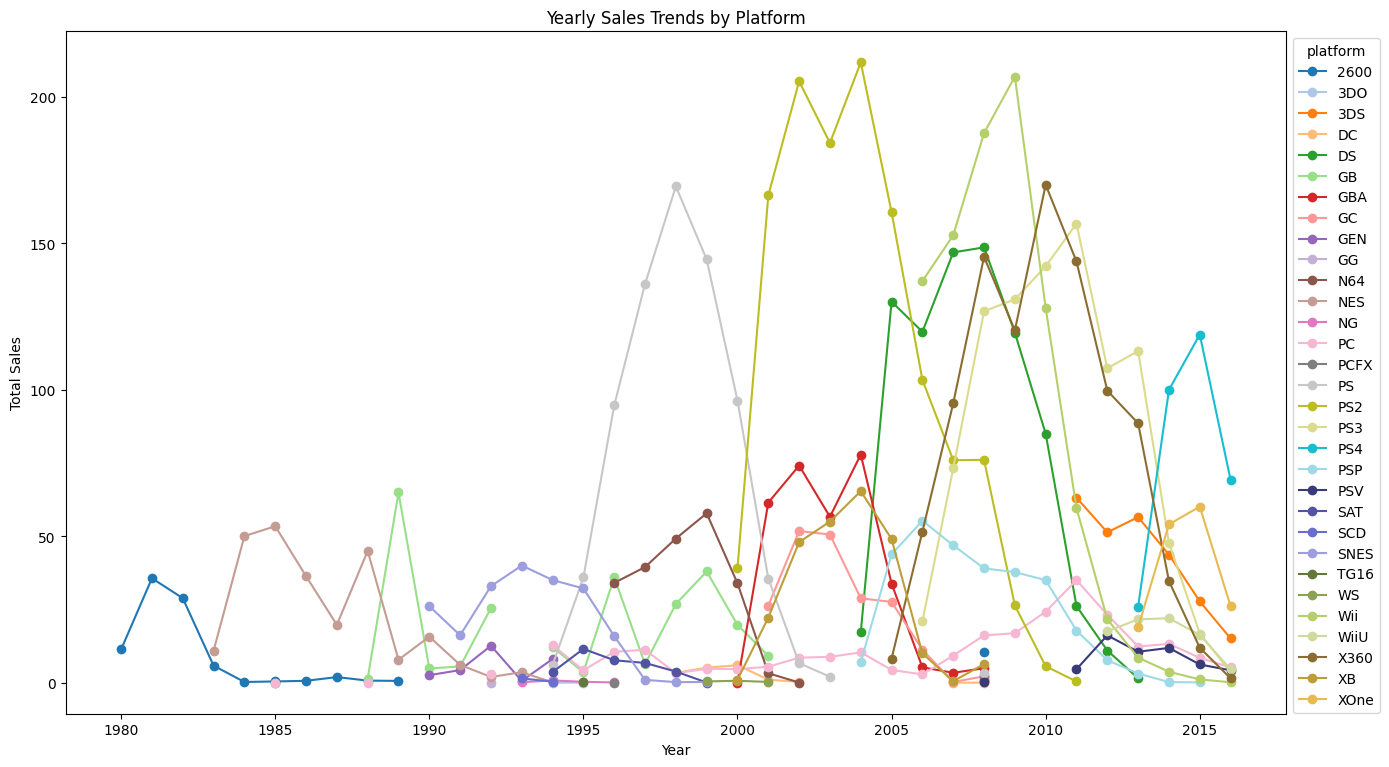

In [407]:
# Grouping by 'Year' and 'Platform' and sum the 'Sales'
year_platform_sales = df_game.groupby(['year_release', 'platform'])['total_sale'].sum().reset_index()

# Creating a pivot table for better visualization
year_platform_sales_pivot = year_platform_sales.pivot(index='year_release', columns='platform', values='total_sale')

# Creating a figure and axis
cmap = plt.get_cmap("tab20")
cmap1 = plt.get_cmap("tab20b")

plt.figure(figsize=(14, 8))

# Plot sales trends for each platform
for i, platform in enumerate(year_platform_sales_pivot.columns):
    if i < 20:
        plt.plot(year_platform_sales_pivot.index, year_platform_sales_pivot[platform], marker='o', label=platform, color=cmap(i))
    else:
        plt.plot(year_platform_sales_pivot.index, year_platform_sales_pivot[platform], marker='o', label=platform, color=cmap1(i-20))

plt.title('Yearly Sales Trends by Platform')
plt.xlabel('Year')
plt.ylabel('Total Sales')

plt.legend(title='platform', loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()

plt.show()

* The chart indicates that there is significant variation in the sale per platform overtime. 

* The highest sale occured in PS2 platform, x360, Wii, PS3, DS, and Ps, respectively. 

* The platform trends up and down, with some fizzling out, and others appearing over time (abot 7 year interval)

In [408]:
df_game.sample()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale,year_release
11850,Sigma Harmonics,DS,2008-01-01,Role-Playing,0.0,0.0,0.07,0.0,70.0,7.7,Not Rated,0.07,2008


Visualing 10 platforms with the greatest total sales Top

In [409]:

total_sales_platform = df_game.groupby('platform')['total_sale'].sum().sort_values(ascending=False) # Calculate Total Sales by Platform

top_platforms_sales = total_sales_platform.head(10).index # 10 Sale by Platform



# Building a Distribution of Sales by Year for the Top 10 Platforms

df_top_platforms_sales = df_game[df_game['platform'].isin(top_platforms_sales)] # Filter the DataFrame for the top 10 platforms only.

top_platforms_yearly_sales = df_top_platforms_sales.groupby(['year_release', 'platform'])['total_sale'].sum().unstack()


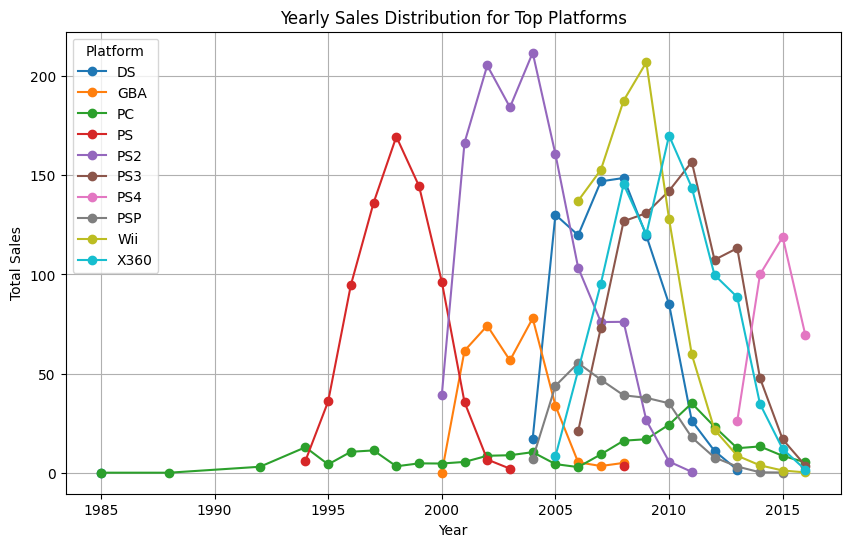

In [410]:
#Visualize the distribution with a line plot
plt.figure(figsize=(10, 6))
for platform in top_platforms_yearly_sales.columns:
    plt.plot(top_platforms_yearly_sales.index, top_platforms_yearly_sales[platform], marker='o', label=platform)
plt.title('Yearly Sales Distribution for Top Platforms')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Platform')
plt.grid(True)
plt.show()

* The platforms that used to be popular but now have zero sales are PS2, PS, DS, and Wii. 

* From the plot, it roughly takes about 6 to 8 years for new platforms to appear and old ones to fade.

* We can take data from 1995 to 2016 to build a model for 2017.

* The platforms that were leading in sales are PS, PS2, Wii, PS3, and X360; but they are almost fading out. 
 
* The PS, PS2, and DS, despite doing will ealier have completely fizzle out. 

* No potentially profitable platforms; Although, PS4, Xone, and 3DS were leading, they were alreading trending downward. 

#Select data that should help to build a model for 2017.

In [411]:
df_selected_game = df_game[df_game['year_release'] > 1995]  #Selecting data from 1995 to 2016
df_selected_game.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16010 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16010 non-null  object        
 1   platform         16010 non-null  object        
 2   year_of_release  16010 non-null  datetime64[ns]
 3   genre            16010 non-null  object        
 4   na_sales         16010 non-null  float64       
 5   eu_sales         16010 non-null  float64       
 6   jp_sales         16010 non-null  float64       
 7   other_sales      16010 non-null  float64       
 8   critic_score     16010 non-null  float64       
 9   user_score       16010 non-null  float64       
 10  rating           16010 non-null  object        
 11  total_sale       16010 non-null  float64       
 12  year_release     16010 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(1), object(4)
memory usage: 1.6+ MB


#Box plot for the global sales of all games, broken down by platform

In [412]:
total_sale_quantile_99 =  df_selected_game.total_sale.quantile(q=0.99) #removing the outliers.
df_selected_game_99 = df_selected_game.loc[df_selected_game.total_sale <= total_sale_quantile_99]

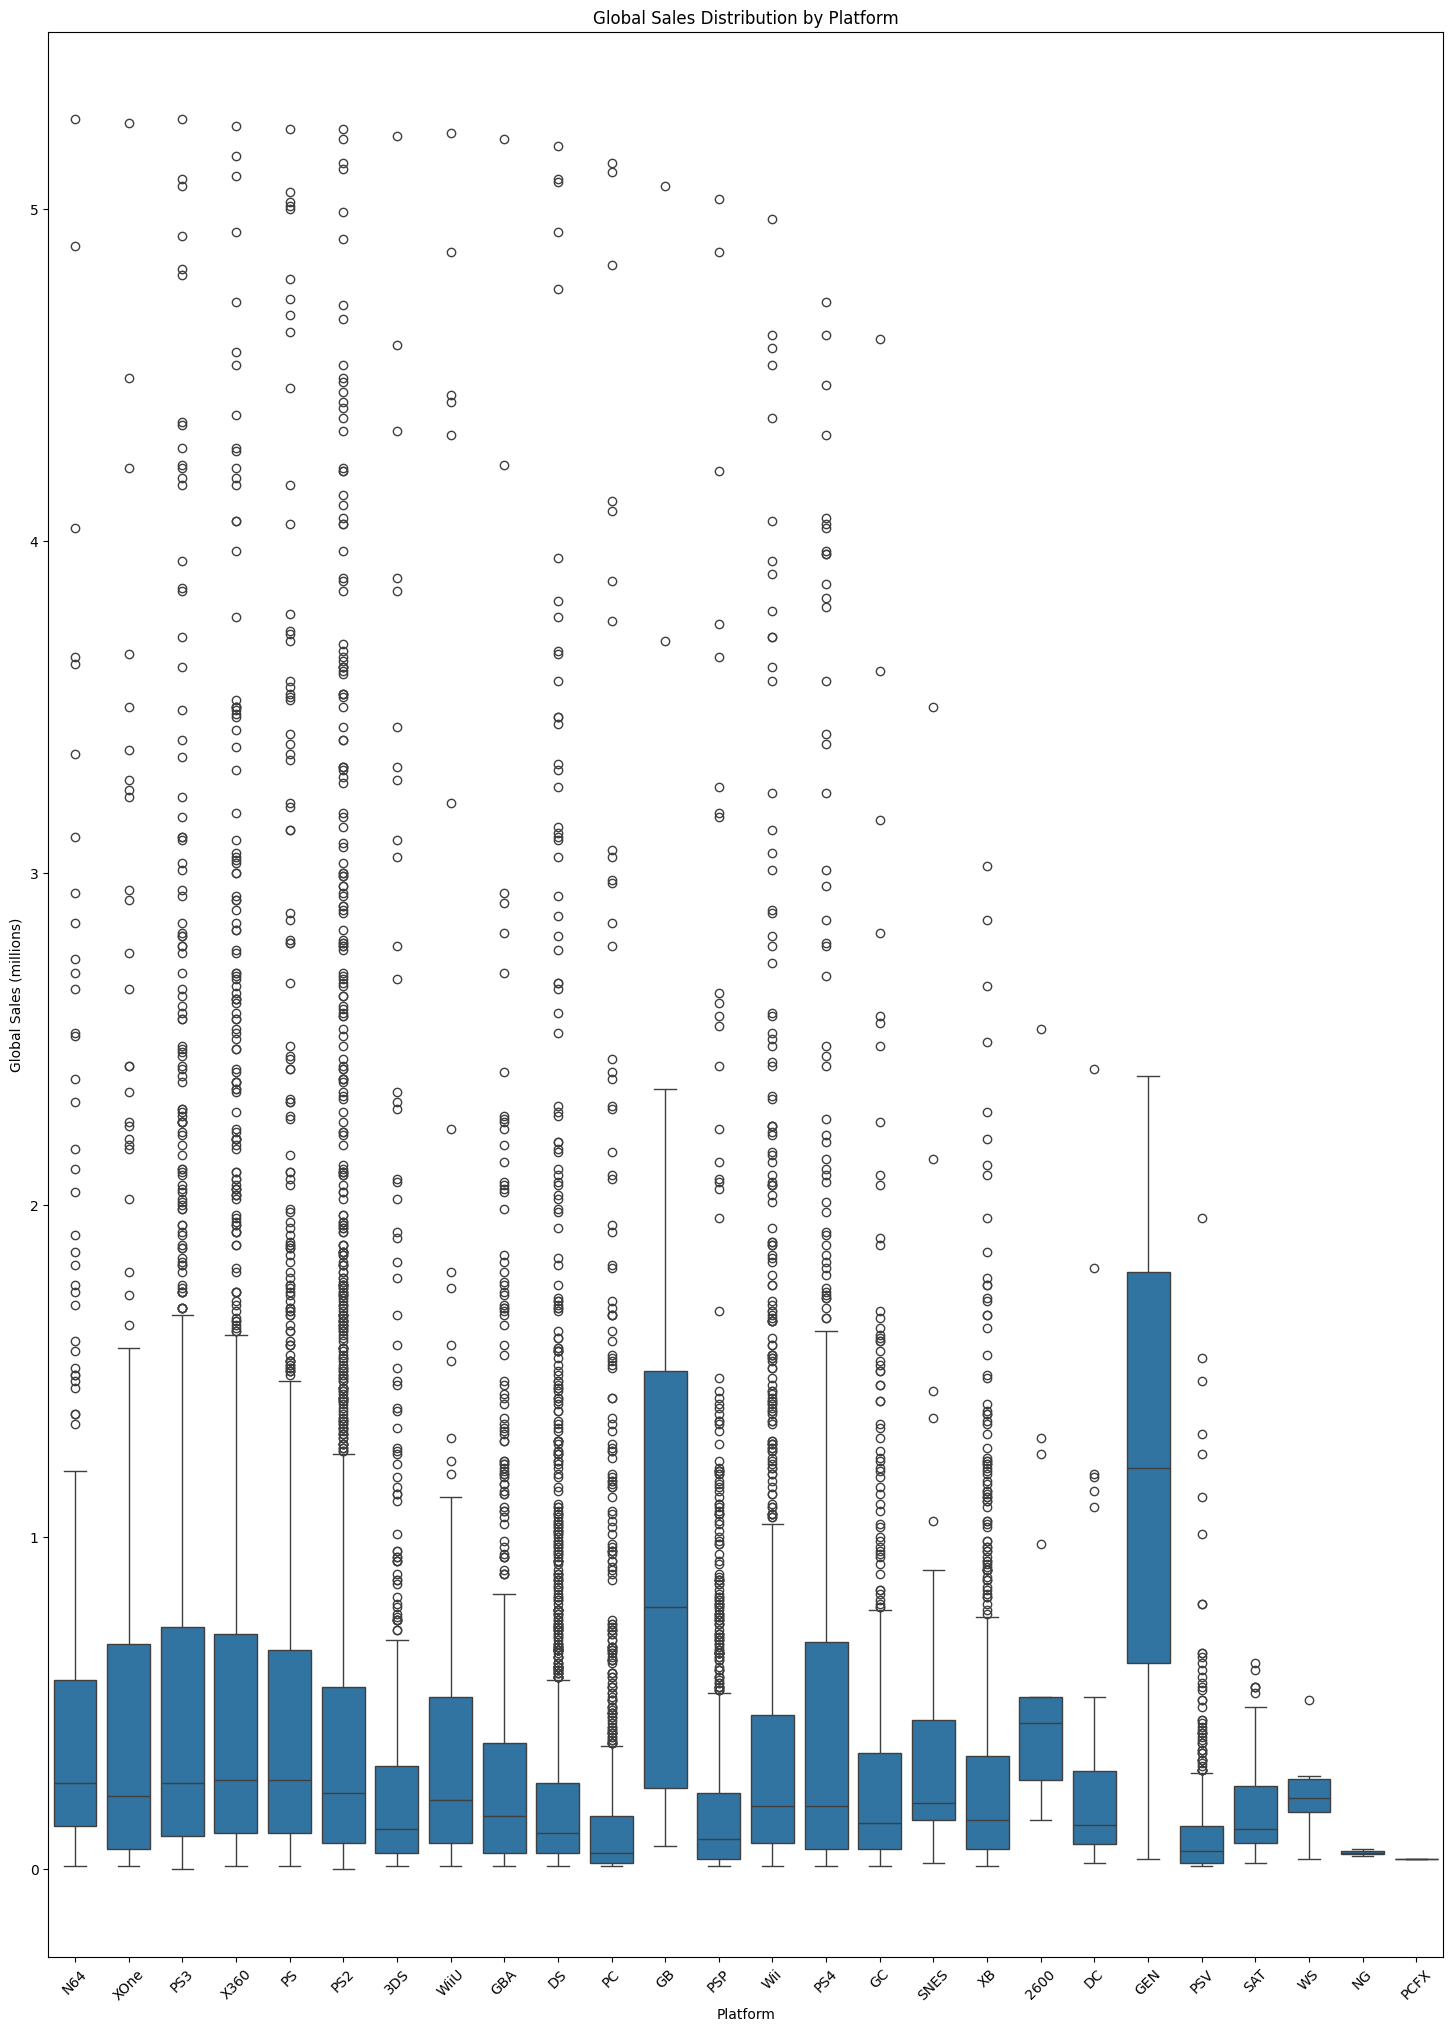

In [413]:
# Plotting the box plot.
plt.figure(figsize=(18, 25))

sns.boxplot(x='platform', y='total_sale', data=df_selected_game_99)
plt.xticks(rotation=45)
plt.title('Global Sales Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Global Sales (millions)')
plt.show()


In [414]:
mean_value = df_selected_game_99.groupby(df_selected_game_99['platform'])['total_sale'].mean()
mean_value

platform
2600    0.617647
3DS     0.342773
DC      0.306731
DS      0.273051
GB      1.009286
GBA     0.329240
GC      0.322984
GEN     1.210000
N64     0.543802
NG      0.050000
PC      0.235141
PCFX    0.030000
PS      0.555234
PS2     0.522129
PS3     0.559288
PS4     0.604162
PSP     0.232709
PSV     0.125744
SAT     0.180098
SNES    0.470000
WS      0.236667
Wii     0.415050
WiiU    0.514384
X360    0.588254
XB      0.295414
XOne    0.597796
Name: total_sale, dtype: float64

* The box plots showed that there are significant variations in the sales per platform.

* Majority of the platforms such as Wii, X360, Ps3,PS4, Xone have outliers that are skewed to the right (indicating high sales).

* Howerver, platforms like GEN and GB are evenly distributed.

* There is significant variation in the mean values of each platform.

Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

Analyze How User and Professional Reviews Affect Sales for a Popular Platform

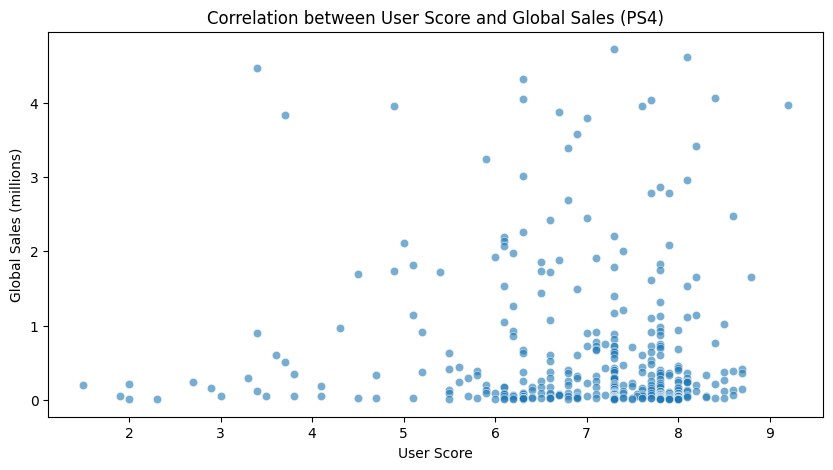

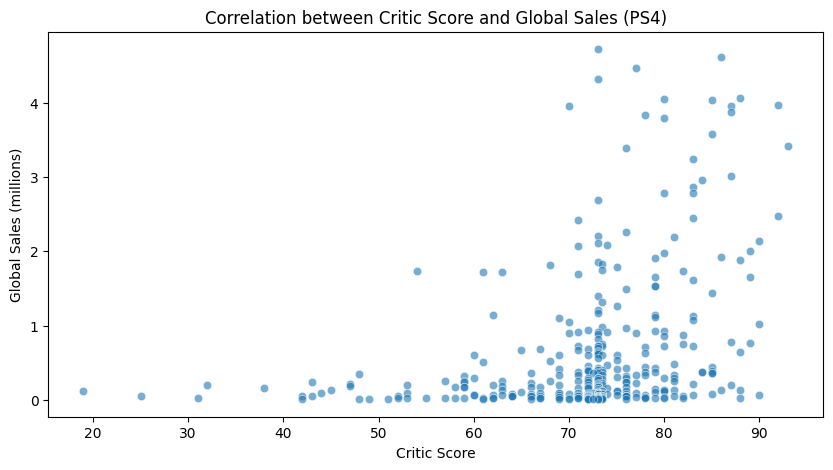

In [415]:
#Building a scatter plot to visualize the correlation using the PlayStation 4 (PS4), since it making the hightest sale at the time. 


df_ps4_global_sales = df_selected_game_99[df_selected_game_99['platform'] == 'PS4'] # Filtering data for PS4

# Scatter plot of user score vs sales
plt.figure(figsize=(10, 5))
sns.scatterplot(x='user_score', y='total_sale', data=df_ps4_global_sales, alpha=0.6)
plt.title('Correlation between User Score and Global Sales (PS4)')
plt.xlabel('User Score')
plt.ylabel('Global Sales (millions)')
plt.show()

# Scatter plot of critic score vs sales
plt.figure(figsize=(10, 5))
sns.scatterplot(x='critic_score', y='total_sale', data=df_ps4_global_sales, alpha=0.6)
plt.title('Correlation between Critic Score and Global Sales (PS4)')
plt.xlabel('Critic Score')
plt.ylabel('Global Sales (millions)')
plt.show()

Calculating correlation for reviews

In [416]:

user_review_corr, _ = pearsonr(df_ps4_global_sales['user_score'], df_ps4_global_sales['total_sale'])
critic_score_corr, _ = pearsonr(df_ps4_global_sales['critic_score'], df_ps4_global_sales['total_sale'])

print(f'Correlation between user score and global sales: {user_review_corr:.4f}')
print(f'Correlation between critic score and global sales: {critic_score_corr:.4f}')


Correlation between user score and global sales: -0.0406
Correlation between critic score and global sales: 0.3427


* From the result, Critic scores have more correlation than User Scores.

* it can be assumed that critic reviews influence sales more than the User score.

* However the correlation is not strong (meaning that reviews may not significantly impact sales).

In [417]:
df_game.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sale,year_release
15492,Crayon Shin-Chan: Uchuu de Achoo!? Yuujou no O...,3DS,2011-01-01,Action,0.00,0.00,0.02,0.00,63.0,6.65,Not Rated,0.02,2011
15189,D.Gray-man: Sousha no Shikaku,PS2,2008-01-01,Adventure,0.00,0.00,0.02,0.00,63.0,7.70,Not Rated,0.02,2008
5955,The LEGO Movie Videogame,PSV,2014-01-01,Action,0.04,0.19,0.00,0.07,70.0,5.60,E10+,0.30,2014
3639,Derby Stallion 04,PS2,2004-01-01,Sports,0.00,0.00,0.55,0.00,74.0,7.90,Not Rated,0.55,2004
8415,Ridge Racer Unbounded,PS3,2012-01-01,Racing,0.05,0.09,0.00,0.03,72.0,6.00,T,0.17,2012


Compare Sales of the Same Games on Other Platforms

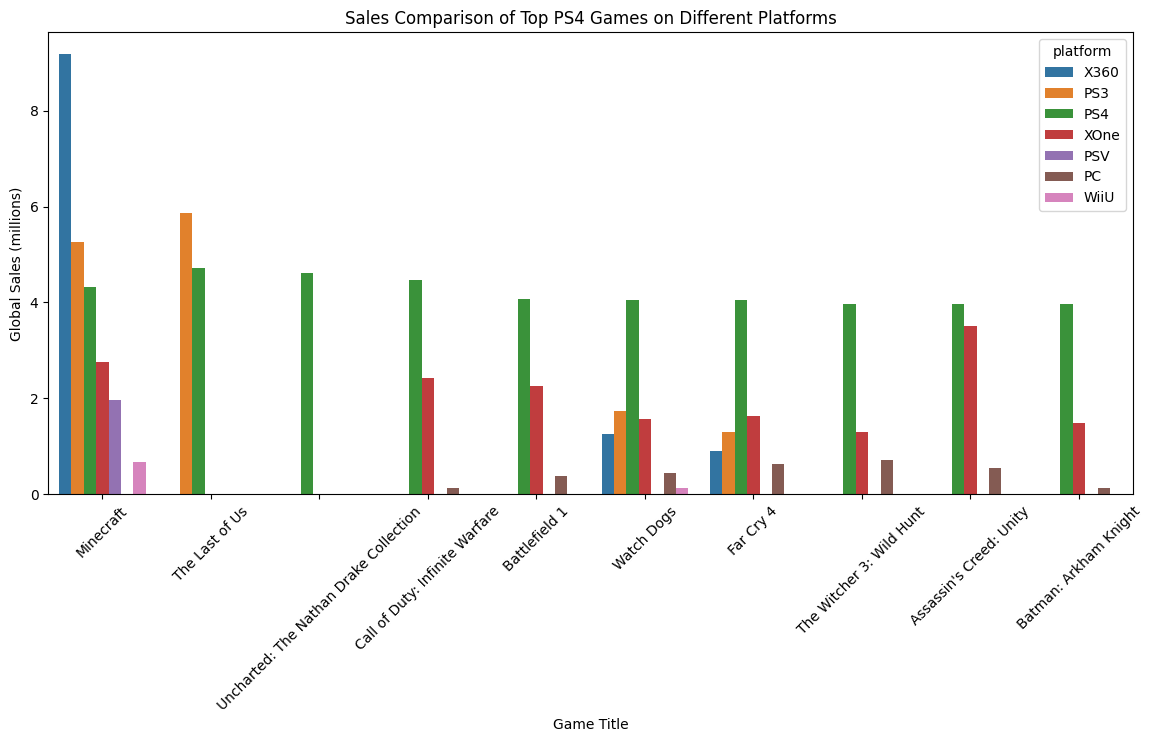

In [418]:


#let’s compare the same games across platforms.


top_ps4_games = df_ps4_global_sales.nlargest(10, 'total_sale')['name'] # Filtering the top-selling games on PS4


df_top_ps4_games = df_game[df_game['name'].isin(top_ps4_games)] # Filtering dataset for the games across all platforms

# Create a bar plot to compare sales across platforms
plt.figure(figsize=(14, 6))
sns.barplot(x='name', y='total_sale', hue='platform', data=df_top_ps4_games)
plt.xticks(rotation=45)
plt.title('Sales Comparison of Top PS4 Games on Different Platforms')
plt.xlabel('Game Title')
plt.ylabel('Global Sales (millions)')
plt.legend(title='platform')
plt.show()


* The variation of the sales per platforms are significant.

* All the game made notable sale on the PS4 and Xone platform

* Grand Theft Auto V" made good high sales across PS3 and X360 (above the average) but other games remained consitently low (below average) across the platform. 
* There might be  exclusivity or better optimization on platforms like the PS4 allowing it to make good sales. 

Distribution of Games by Genre

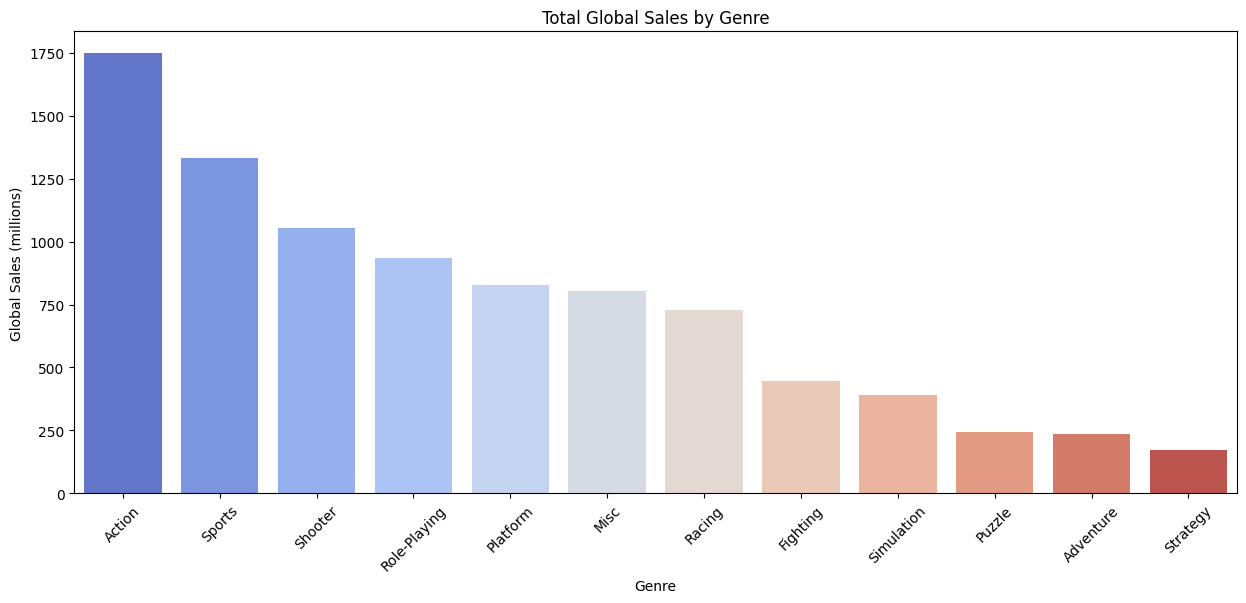

In [419]:
#Distribution of Games by Genre

genre_game_sales = df_game.groupby('genre')['total_sale'].sum().sort_values(ascending=False) # Aggregate sales by genre

# Plot total sales by genre
plt.figure(figsize=(15, 6))
sns.barplot(x=genre_game_sales.index, y=genre_game_sales.values, palette='coolwarm', hue=genre_game_sales.index, legend=False )
plt.xticks(rotation=45)
plt.title('Total Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Global Sales (millions)')
plt.show()


* The highest-selling genres might be action, sports, shooter, Role_Playing, Platform Misc, respectively.

* Therefore, action, sport and Shooter games are most profitable and should be promoted more. 

* It can be said that the genres impacts the sales.


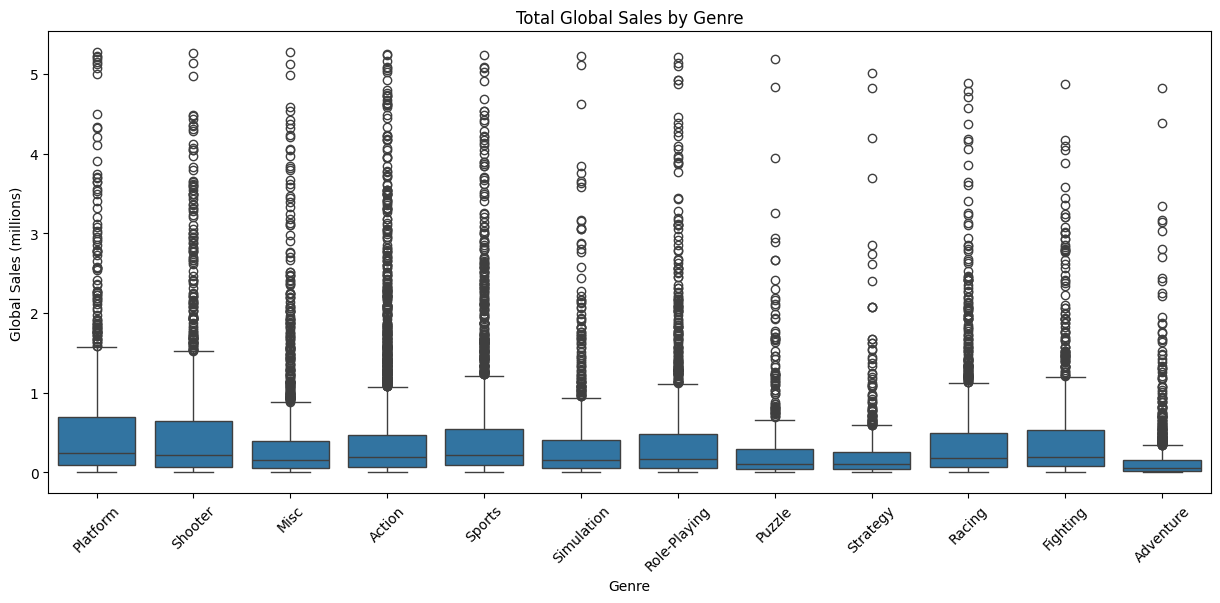

In [420]:
# Plotting total sales by genre
plt.figure(figsize=(15, 6))
sns.boxplot(data= df_game.loc[df_game.total_sale < total_sale_quantile_99],  x="genre", y="total_sale") #ploting the sales after removing the outliers. 
plt.xticks(rotation=45)
plt.title('Total Global Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Global Sales (millions)')
plt.show()

* The highest-selling genres might be action, sports, shooter, Role_Playing, Platform Misc, respectively.

* Therefore, action, sport and Shooter games are most profitable and should be promoted more. 

* It can be said that the genres impacts the sales.

# Step 4. Create a user profile for each region

Analyze the top five platforms, top five genres, and the impact of ESRB ratings on sales for NA (North America), EU (Europe), and JP (Japan).

Analyzing the top five platforms and the variations in their market shares from region to region.

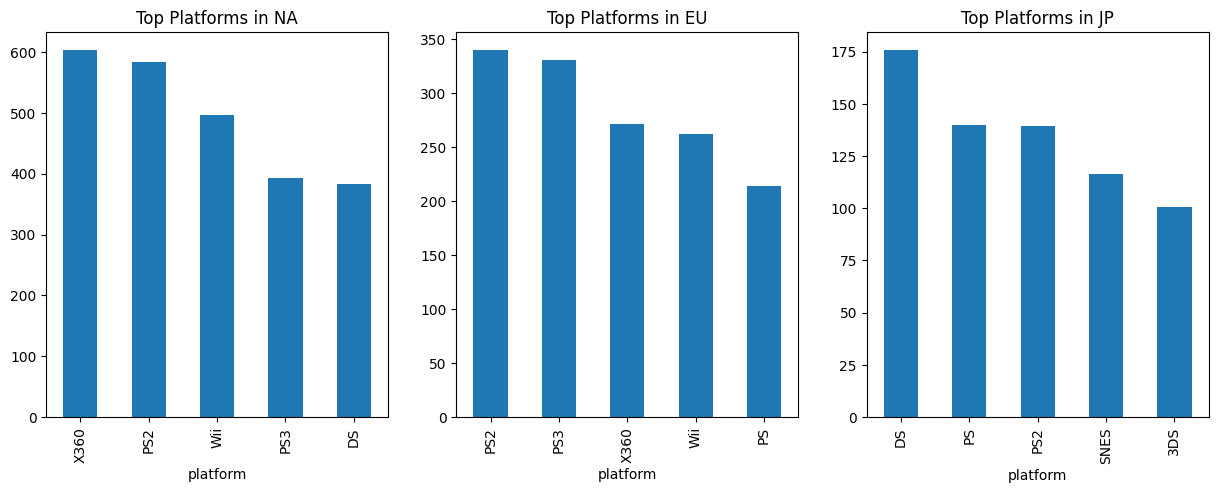

In [421]:

platform_sales_region = df_game.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum() # Group by Platform and sum sales for each region

# Getting the top 5 platforms for each region
top_platforms_na =platform_sales_region.nlargest(5, 'na_sales')
top_platforms_eu = platform_sales_region.nlargest(5, 'eu_sales')
top_platforms_jp = platform_sales_region.nlargest(5, 'jp_sales')

# Visualizing market share variations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

top_platforms_na['na_sales'].plot(kind='bar', ax=axes[0], title='Top Platforms in NA')
top_platforms_eu['eu_sales'].plot(kind='bar', ax=axes[1], title='Top Platforms in EU')
top_platforms_jp['jp_sales'].plot(kind='bar', ax=axes[2], title='Top Platforms in JP')

plt.show()

#Analysis of Market Share Variations:


* NA had the highest sales in all platform, followed by the EU; The JP had the least sales. 

* NA is dominated by X360, PS2, and Wii; the is EU dominated PS2 and PS3; Whereas JP is dorminated DS. 

* The PS2 platform had a noticable sale in all the region, with NA having highest sale, followed for EU, and JP having the least sale. 

* The PS3 have similar sale in both NA and EU.

 Determine the Top Five Genres in Each Region and Analyze total sales by genre in each region

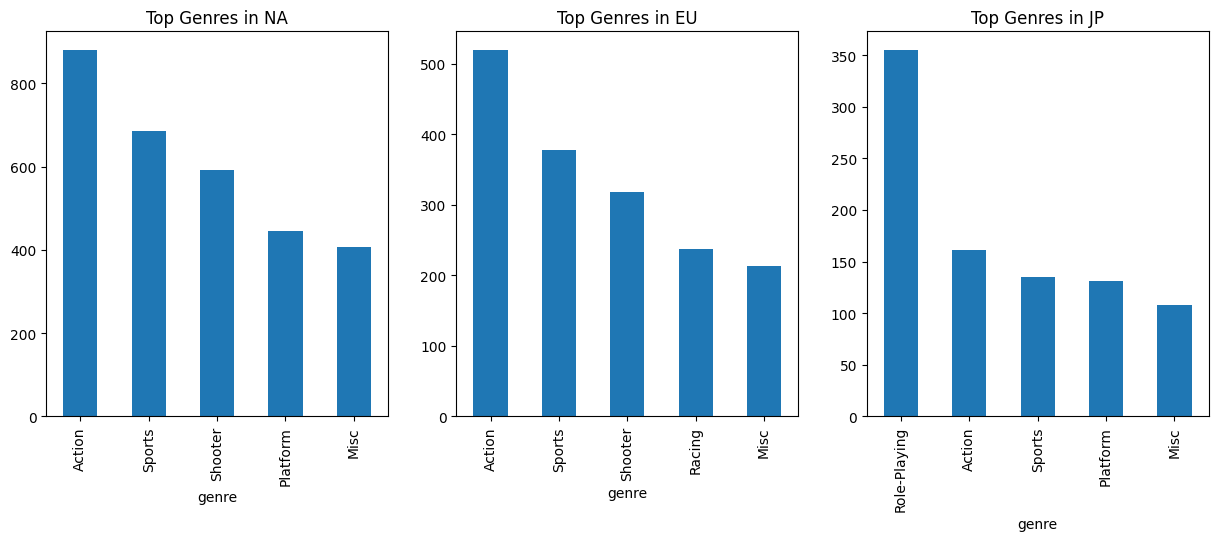

In [422]:
genre_sales = df_game.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum() #Group by Genre and sum sales for each region

# Get top 5 genres for each region
top_genres_na = genre_sales.nlargest(5, 'na_sales')
top_genres_eu = genre_sales.nlargest(5, 'eu_sales')
top_genres_jp = genre_sales.nlargest(5, 'jp_sales')

# Plotting the sales distribution for each region
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

top_genres_na['na_sales'].plot(kind='bar', ax=axes[0], title='Top Genres in NA')
top_genres_eu['eu_sales'].plot(kind='bar', ax=axes[1], title='Top Genres in EU')
top_genres_jp['jp_sales'].plot(kind='bar', ax=axes[2], title='Top Genres in JP')

plt.show()

* The NA genre made highest sales, followed by genre EU, and JP.

* In NA and EU, Action made hightes sales, followed Sport, and then Shooter. 

* The Misc genre made the lowerst sale in all the three platform. 

* Role_Playing made the highest sales in JP. 

Do ESRB Ratings Affect Sales in Each Region?

Text(0.5, 1.0, 'top 5 ESRB rating by sales in EU')

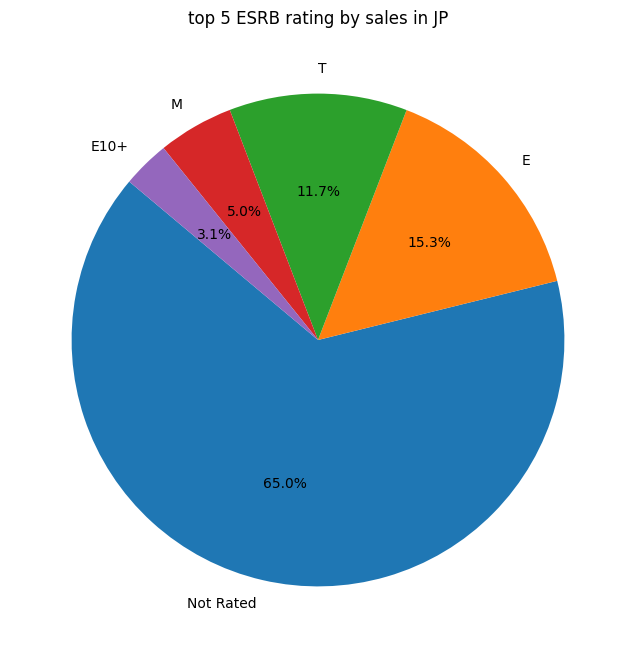

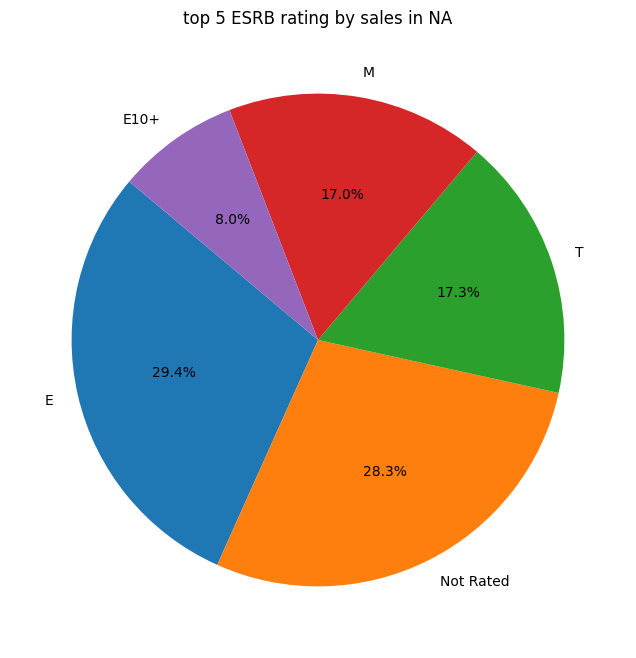

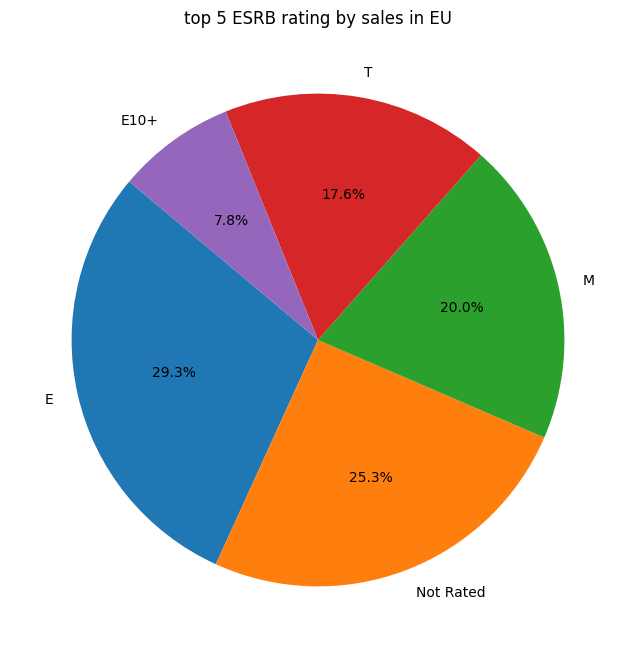

In [423]:
jp_rating_sales  = df_game.groupby('rating')['jp_sales'].sum().reset_index().sort_values(by='jp_sales', ascending=False)
plt.figure(figsize=(8,8))
plt.pie(jp_rating_sales.head(5)['jp_sales'], labels=jp_rating_sales.head(5)['rating'], autopct="%1.1f%%", startangle=140)
plt.title("top 5 ESRB rating by sales in JP")

na_rating_sales  = df_game.groupby('rating')['na_sales'].sum().reset_index().sort_values(by='na_sales', ascending=False)
plt.figure(figsize=(8,8))
plt.pie(na_rating_sales.head(5)['na_sales'], labels=na_rating_sales.head(5)['rating'], autopct="%1.1f%%", startangle=140)
plt.title("top 5 ESRB rating by sales in NA")

eu_rating_sales  = df_game.groupby('rating')['eu_sales'].sum().reset_index().sort_values(by='eu_sales', ascending=False)
plt.figure(figsize=(8,8))
plt.pie(eu_rating_sales.head(5)['eu_sales'], labels=eu_rating_sales.head(5)['rating'], autopct="%1.1f%%", startangle=140)
plt.title("top 5 ESRB rating by sales in EU")

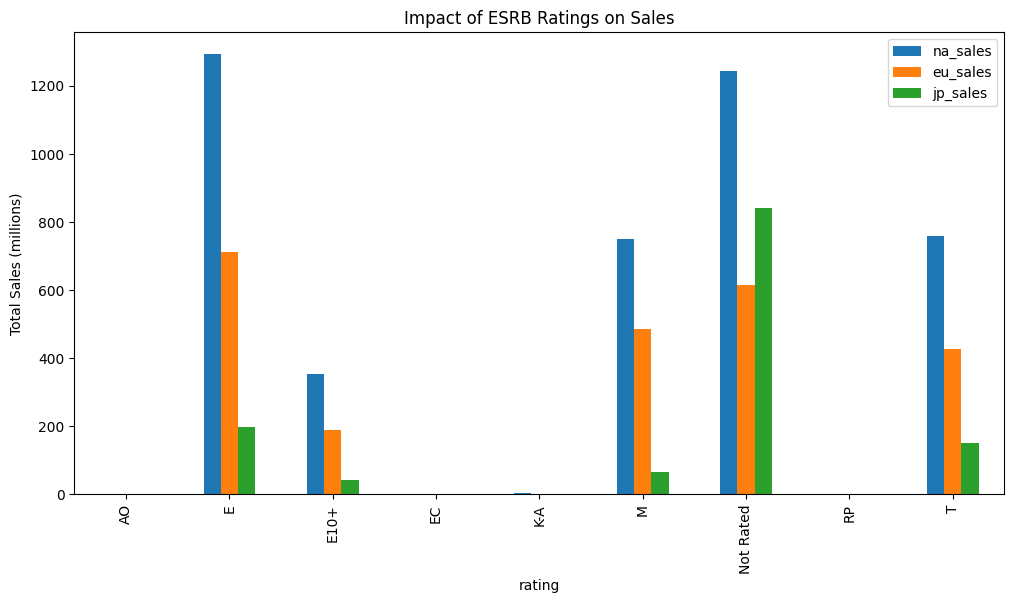

In [ ]:
#We analyze total sales per ESRB rating across different regions.

esrb_sales = df_game.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum() # Group by ESRB rating and sum sales

# Visualizing ESRB rating impact
esrb_sales.plot(kind='bar', figsize=(12, 6), title='Impact of ESRB Ratings on Sales')
plt.ylabel('Total Sales (millions)')
plt.show()

* Most of the games that made good sales were not rated. 

* The games rated E (Everyone) had the high  sales in all the region.

* The T-rated (teen) had strong sales in JP and NA. 

* M-rated games (Mature) have strong sales in EU. 

* The rating sales may be associated to shooter, sport and action games which made high sales.

Step 5. Test the following hypotheses:


Statistical Test two independent events:

alpha = 0.05 #
α = 0.05 (5%) is usually the standard significance level (standard threshold)

1. Hypothesis testing: 
Average user ratings of the Xbox One and PC platforms are the same. 

Formulating Hypotheses:

• Null Hypothesis (H₀): The average user ratings for Xbox One and PC are the same.

• Alternative Hypothesis (H₁): The average user ratings for Xbox One and PC are different.

In [425]:
# Filtering user ratings for Xbox One and PC
xbox_ratings_hyp = df_game[df_game['platform'] == 'XOne']['user_score']
pc_ratings_hyp = df_game[df_game['platform'] == 'PC']['user_score']


t_stat, p_value = ttest_ind(xbox_ratings_hyp, pc_ratings_hyp, equal_var=False) # Perform an independent t-test

alpha = 0.05 #the standard threshold

# Printing results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.8f}")
if p_value < alpha:
    print("Reject the null hypothesis: User ratings for Xbox One and PC are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in user ratings.")


T-statistic: -6.1183, P-value: 0.00000000
Reject the null hypothesis: User ratings for Xbox One and PC are significantly different.


2. Hypothesis testing:
Average user ratings for the Action and Sports genres are different.


Formulating Hypotheses:

• Null Hypothesis (H₀): The average user ratings for Action and Sports games are the same.

• Alternative Hypothesis (H₁): The average user ratings for Action and Sports games are different.

In [426]:
# Filtering user ratings for Action and Sports genres
action_ratings = df_game[df_game['genre'] == 'Action']['user_score']
sports_ratings = df_game[df_game['genre'] == 'Sports']['user_score']


t_stat, p_value = ttest_ind(action_ratings, sports_ratings, equal_var=False) # Performing an independent t-test

alpha = 0.05 #the standard threshold

# Printing results:
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.6f}")
if p_value < alpha:
    print("Reject the null hypothesis: User ratings for Action and Sports genres are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in user ratings.")


T-statistic: -3.19, P-value: 0.001436
Reject the null hypothesis: User ratings for Action and Sports genres are significantly different.


# Step 6. Write a general conclusion

* The platform, genre, and region sigificatnly impact the sales. Genre like action, sport, and shooter should be promoted more as they made the highest sales. 
* platform like SP4 made great sales. Optimizing platforms may have significant impact on the sale. More sales were made in NA more than any other platform. 
* User score does not appear to have any impact on the sale, and may not be necessary. 
* The hypotheses testing showed that User ratings for Action and Sports genres are significantly different; 
User ratings for Xbox One and PC are significantly different.

* Critic sore has weak correlation with the sales.
* Further analysis can be done to understand what platforms and regions that made great sales did as oppose to other regions and platforms.